In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.signal as signal
from pathlib import Path

# Constants
SAMPLING_RATE = 500  # Hz
ecq_folder = "../../../Datasets/12-lead electrocardiogram database/ECGData"
diagnostics_file = "../../../Datasets/12-lead electrocardiogram database/Diagnostics.xlsx"
OUTPUT_FOLDER = "eda_plot"

# Rhythm mapping
rhythm_mapping = {
    'AFIB': 'AFIB',
    'AF': 'AFIB',
    'SVT': 'GSVT',
    'AT': 'GSVT',
    'SAAWR': 'GSVT',
    'ST': 'GSVT',
    'AVNRT': 'GSVT',
    'AVRT': 'GSVT',
    'SB': 'SB',
    'SR': 'SR',
    'SA': 'SR'
}

# Create output folder if it does not exist
Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)


In [20]:
# Load Diagnostics data
diagnostics = pd.read_excel(diagnostics_file)

# Step 1: Check for null values and basic statistics
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing Values in Diagnostics Data:")
    print(missing_values)
    print("\nBasic Statistics:")
    print(df.describe())

check_missing_values(diagnostics)

Missing Values in Diagnostics Data:
FileName           0
Rhythm             0
Beat               0
PatientAge         0
Gender             0
VentricularRate    0
AtrialRate         0
QRSDuration        0
QTInterval         0
QTCorrected        0
RAxis              0
TAxis              0
QRSCount           0
QOnset             0
QOffset            0
TOffset            0
dtype: int64

Basic Statistics:
         PatientAge  VentricularRate   AtrialRate   QRSDuration    QTInterval  \
count  10646.000000     10646.000000  10646.00000  10646.000000  10646.000000   
mean      59.186831        84.136107     92.57787     90.989292    384.150855   
std       18.030019        34.455349     60.09394     17.479540     59.226289   
min        4.000000        34.000000      0.00000     18.000000    114.000000   
25%       49.000000        57.000000     57.00000     80.000000    344.000000   
50%       62.000000        73.000000     72.00000     88.000000    390.000000   
75%       72.000000       104

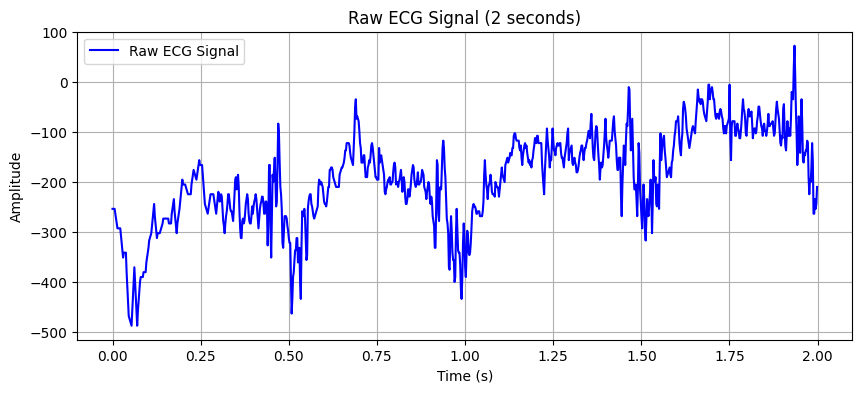

In [21]:
# Step 2: Plot raw ECG data
def plot_raw_ecg(file_name, duration=2):
    file_path = os.path.join(ecq_folder, file_name)
    ecg_data = pd.read_csv(file_path, skiprows=1, header=None).iloc[:, 0]
    time = np.linspace(0, 10, len(ecg_data))
    sample_points = int(SAMPLING_RATE * duration)

    plt.figure(figsize=(10, 4))
    plt.plot(time[:sample_points], ecg_data[:sample_points], label="Raw ECG Signal", color="blue")
    plt.title("Raw ECG Signal (2 seconds)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_FOLDER, "raw_ecg_signal.png"), dpi=300, transparent=True)
    plt.show()

# Pick a random ECG file for raw signal plotting
sample_file = diagnostics.iloc[0]['FileName']
sample_file = sample_file + ".csv"
plot_raw_ecg(sample_file)

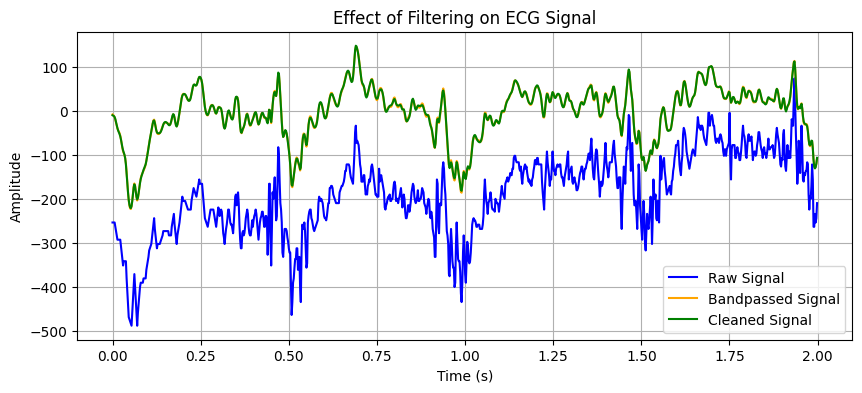

In [22]:
# Step 3: Clean the ECG signal with filters
def clean_ecg_signal(ecg_data):
    # Bandpass filter (0.5-50 Hz)
    lowcut = 0.5
    highcut = 50.0
    nyquist = 0.5 * SAMPLING_RATE
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(1, [low, high], btype="band")
    bandpassed = signal.filtfilt(b, a, ecg_data)

    # Notch filter at 50 Hz
    notch_freq = 50.0
    quality_factor = 30.0
    b_notch, a_notch = signal.iirnotch(notch_freq / nyquist, quality_factor)
    cleaned_signal = signal.filtfilt(b_notch, a_notch, bandpassed)

    return bandpassed, cleaned_signal

def plot_cleaning_effect(ecg_data, bandpassed, cleaned_signal):
    time = np.linspace(0, 10, len(ecg_data))

    plt.figure(figsize=(10, 4))
    plt.plot(time[:1000], ecg_data[:1000], label="Raw Signal", color="blue")
    plt.plot(time[:1000], bandpassed[:1000], label="Bandpassed Signal", color="orange")
    plt.plot(time[:1000], cleaned_signal[:1000], label="Cleaned Signal", color="green")
    plt.title("Effect of Filtering on ECG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_FOLDER, "cleaning_effect.png"), dpi=300, transparent=True)
    plt.show()

file_path = os.path.join(ecq_folder, sample_file)
ecq_data = pd.read_csv(file_path, skiprows=1, header=None).iloc[:, 0]
bandpassed, cleaned = clean_ecg_signal(ecq_data)
plot_cleaning_effect(ecq_data, bandpassed, cleaned)

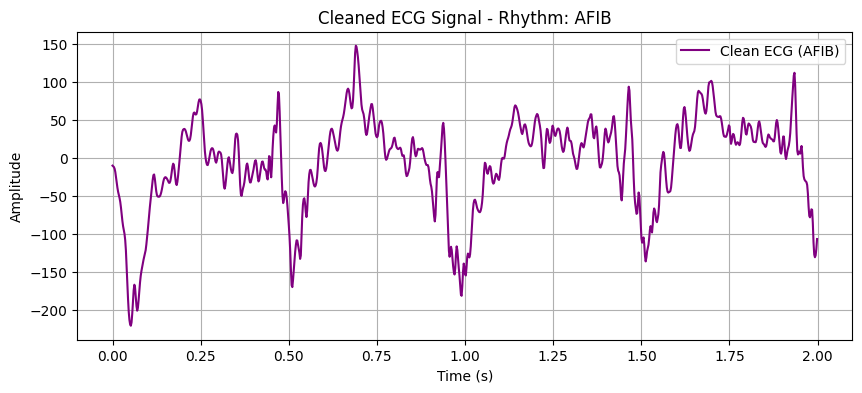

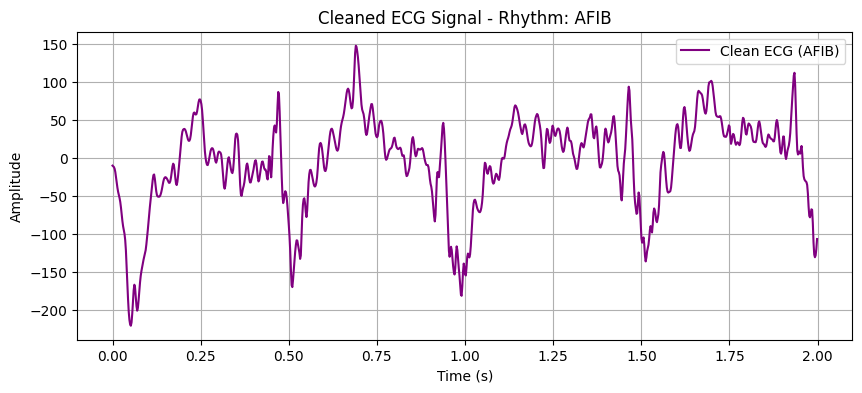

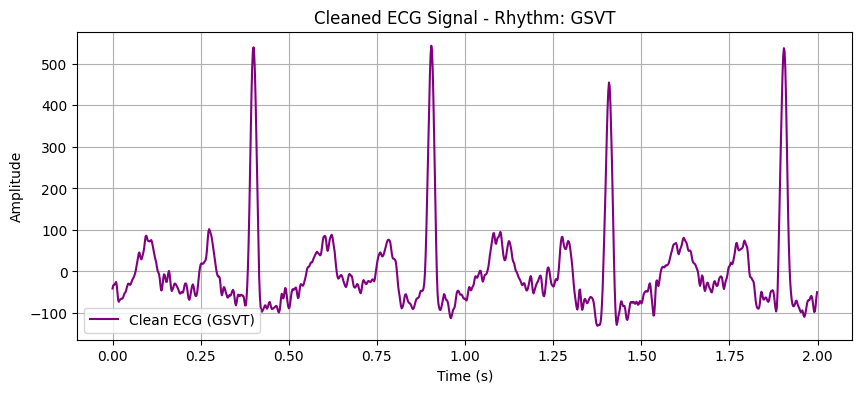

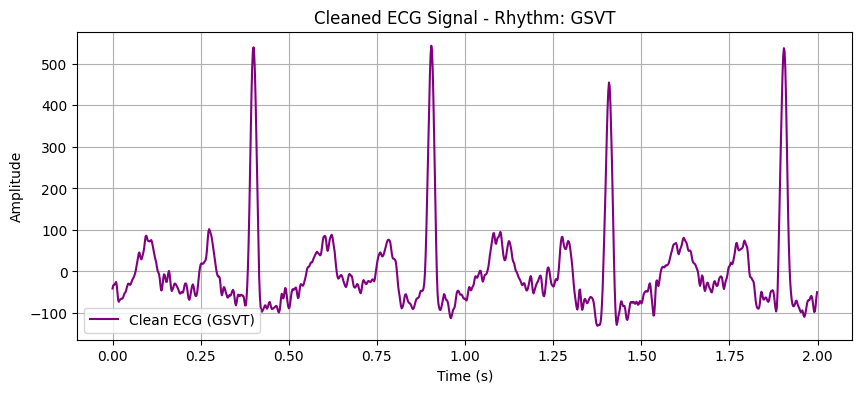

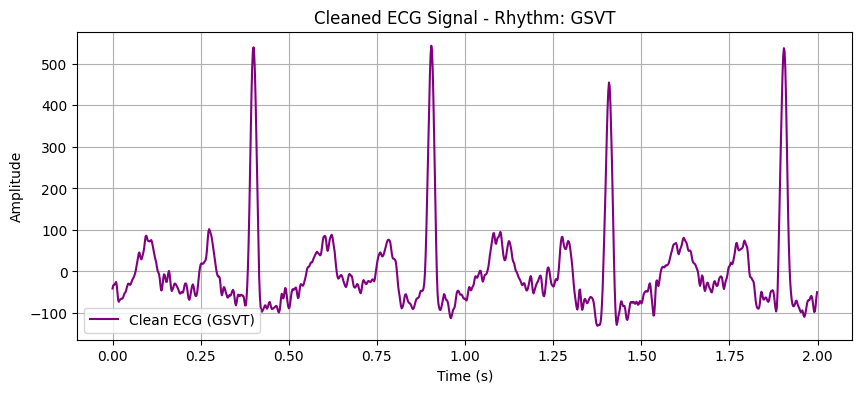

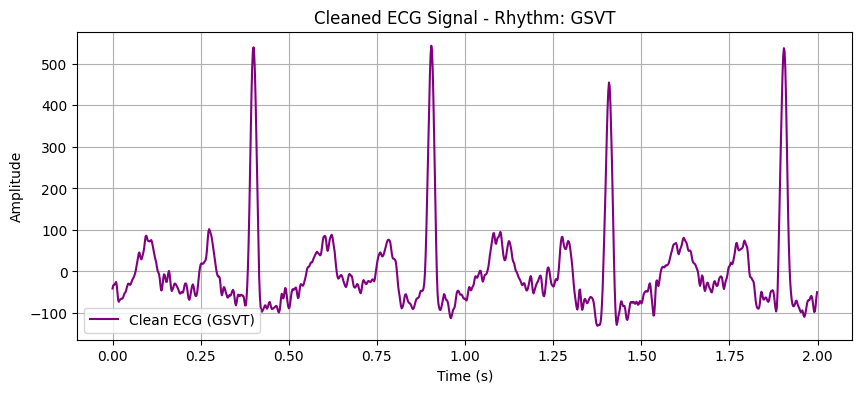

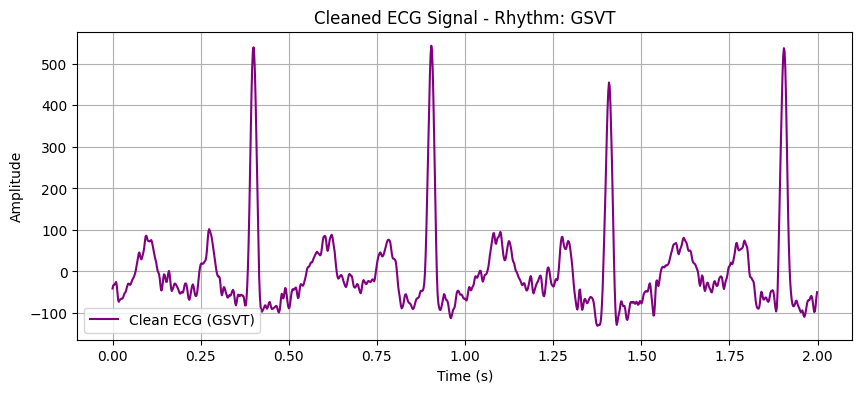

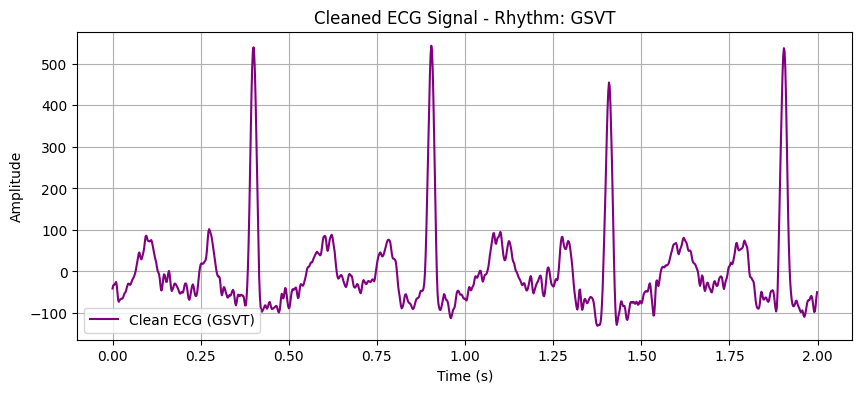

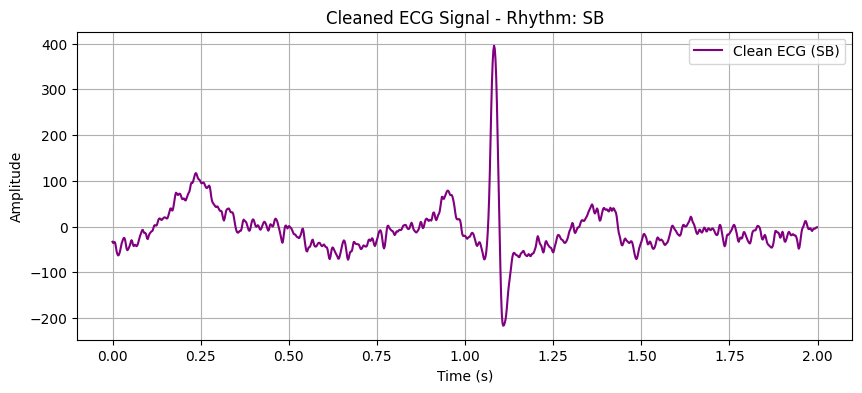

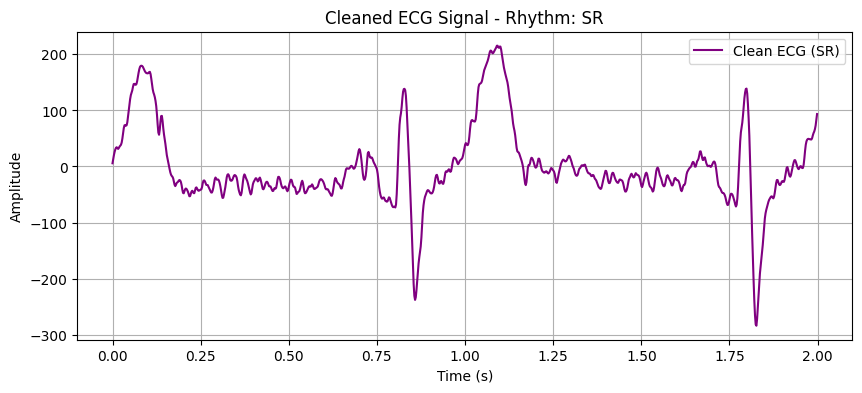

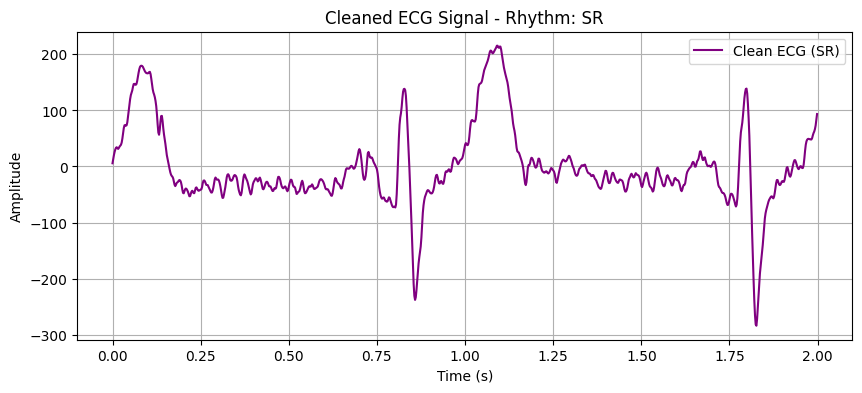

In [23]:
# Step 4: Map rhythms and plot clean ECG signals for each rhythm
def plot_rhythms(df, cleaned_signals):
    mapped_rhythms = df['Rhythm'].map(rhythm_mapping)
    df['MappedRhythm'] = mapped_rhythms

    for rhythm in rhythm_mapping.values():
        rhythm_files = df[df['MappedRhythm'] == rhythm]['FileName']
        if len(rhythm_files) > 0:
            sample_file = rhythm_files.iloc[0] + ".csv"
            file_path = os.path.join(ecq_folder, sample_file)
            ecg_data = pd.read_csv(file_path, header=0).iloc[:, 0]
            _, cleaned_signal = clean_ecg_signal(ecg_data)
            time = np.linspace(0, 10, len(cleaned_signal))

            plt.figure(figsize=(10, 4))
            plt.plot(time[:1000], cleaned_signal[:1000], label=f"Clean ECG ({rhythm})", color="purple")
            plt.title(f"Cleaned ECG Signal - Rhythm: {rhythm}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(OUTPUT_FOLDER, f"cleaned_signal_{rhythm}.png"), dpi=300, transparent=True)
            plt.show()

plot_rhythms(diagnostics, cleaned)

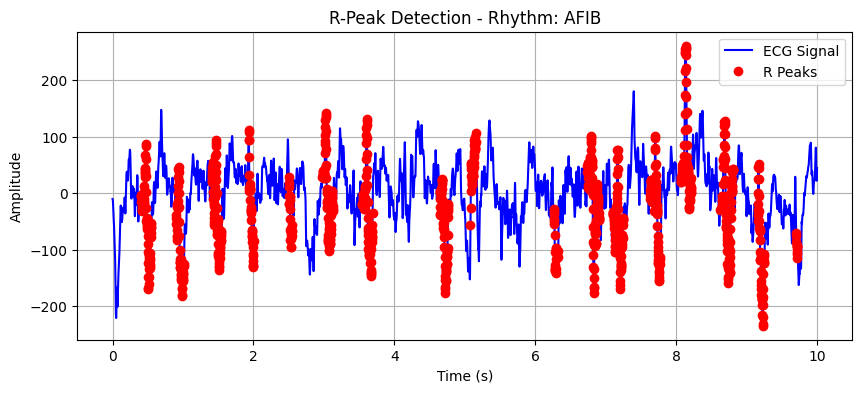

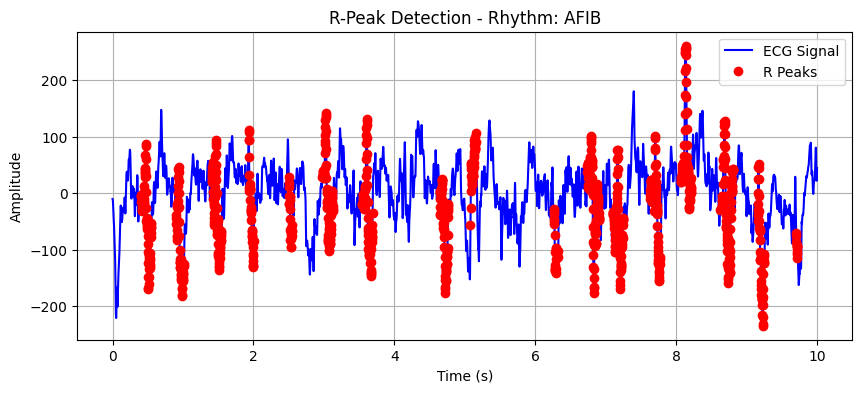

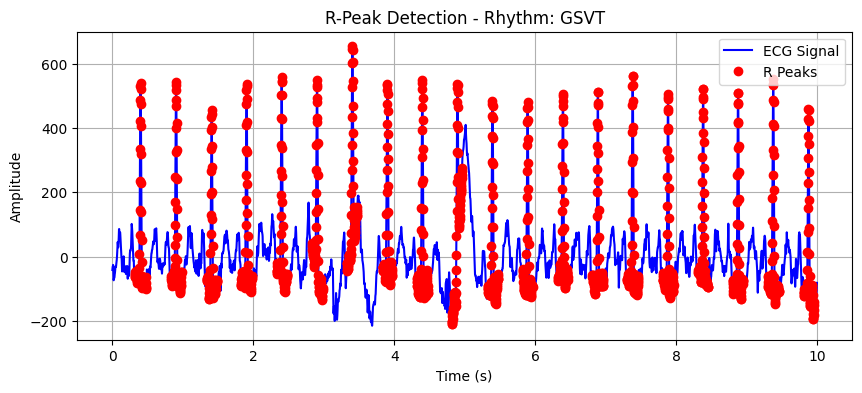

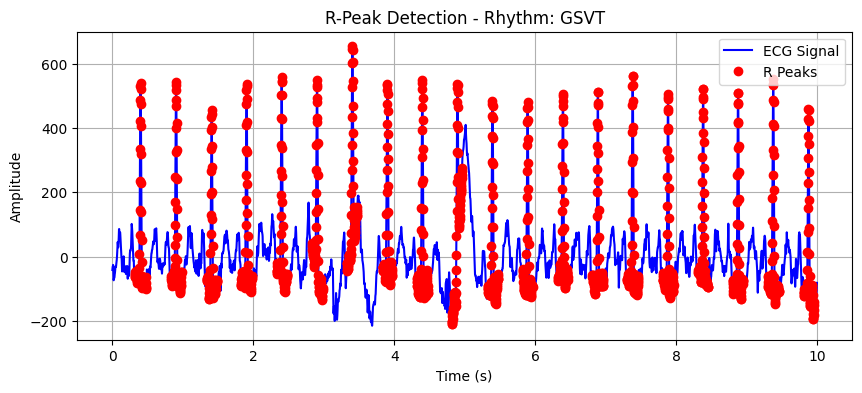

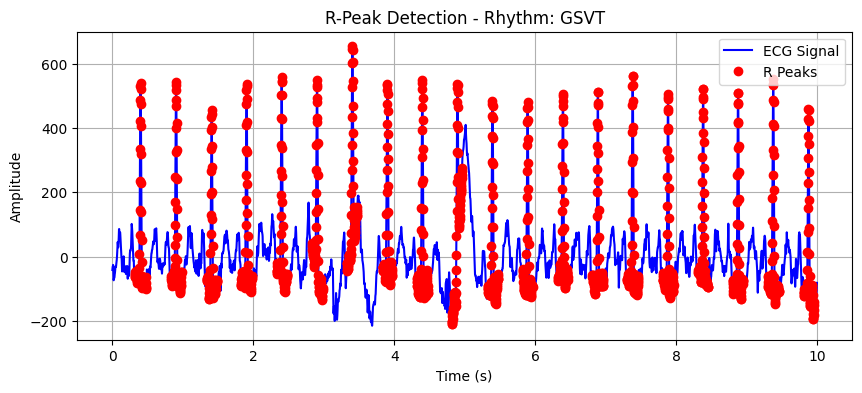

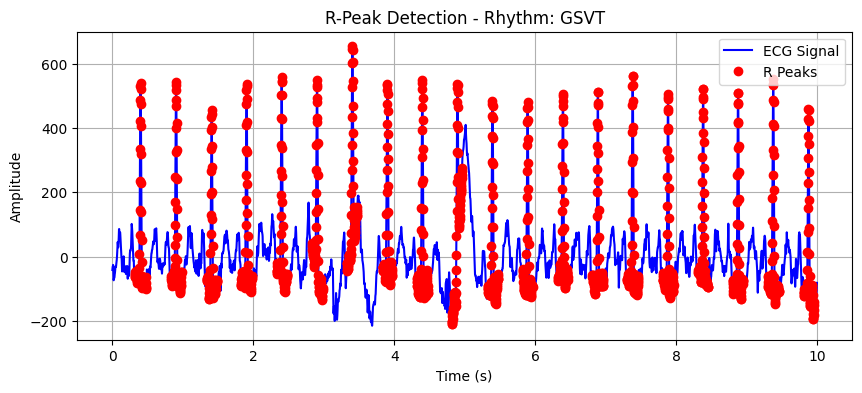

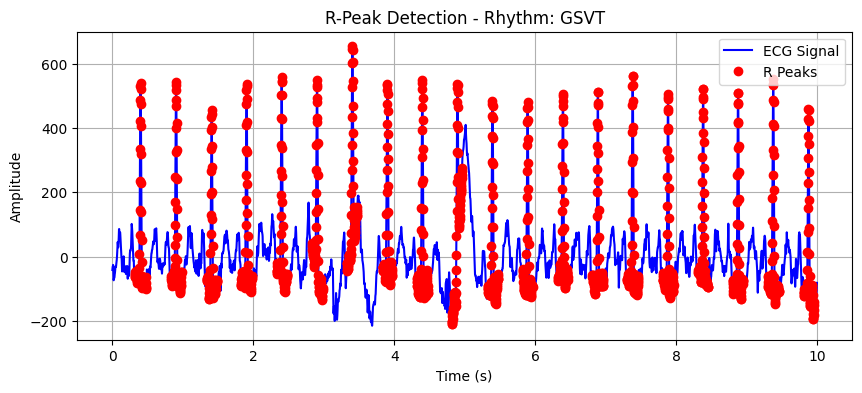

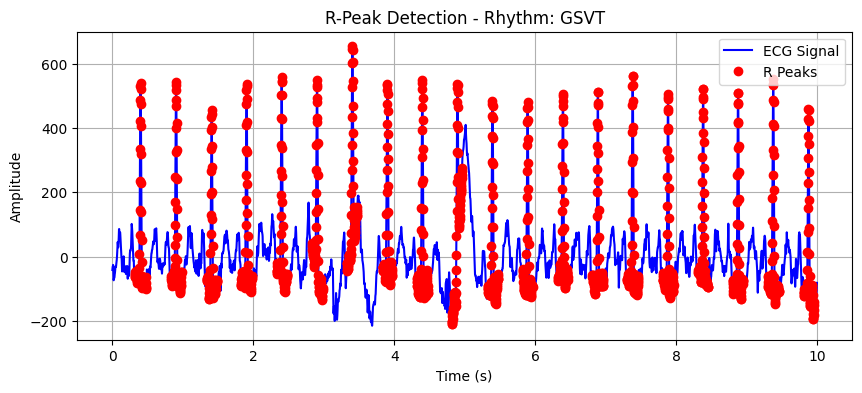

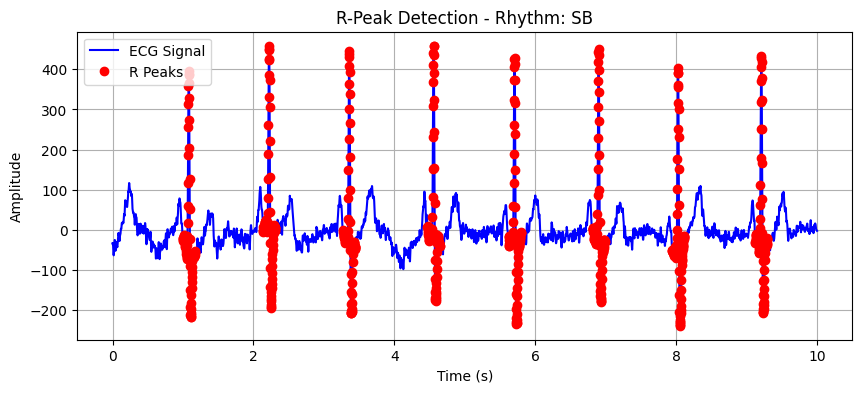

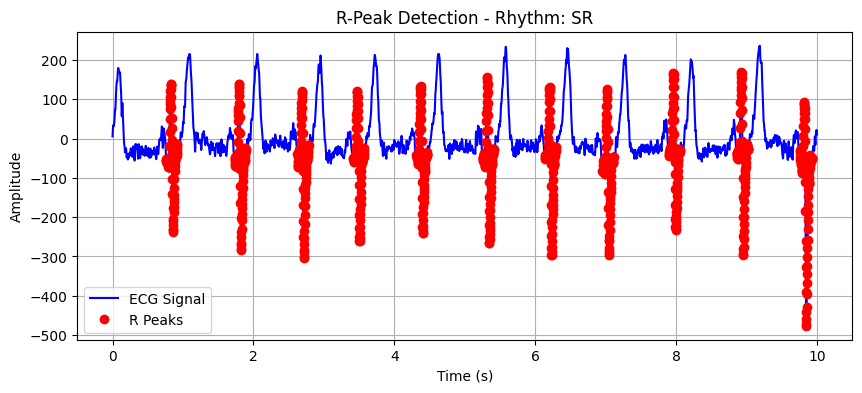

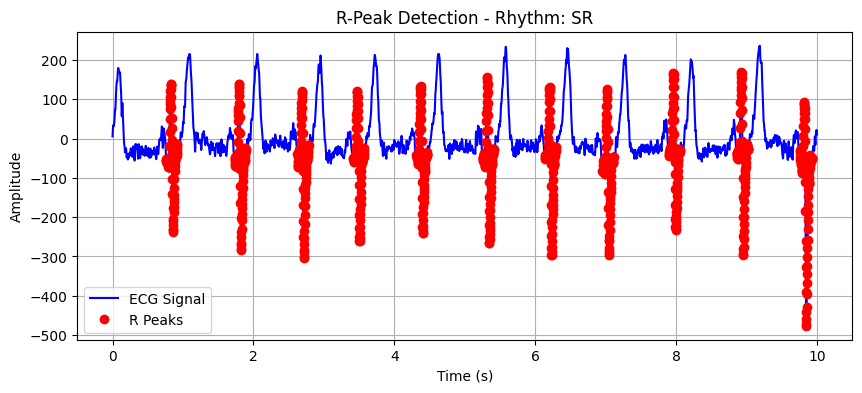

In [24]:
# Step 5: R-peak detection using Pan-Tompkins algorithm
def detect_r_peaks(ecg_data):
    diff_signal = np.diff(ecg_data)
    squared_signal = diff_signal ** 2
    window_size = int(0.15 * SAMPLING_RATE)  # 150ms window
    integrated_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode="same")
    threshold = np.mean(integrated_signal) * 1.5
    r_peaks = np.where(integrated_signal > threshold)[0]
    return r_peaks

def plot_r_peaks(ecg_data, r_peaks, rhythm):
    time = np.linspace(0, 10, len(ecg_data))

    plt.figure(figsize=(10, 4))
    plt.plot(time, ecg_data, label="ECG Signal", color="blue")
    plt.plot(time[r_peaks], ecg_data[r_peaks], 'ro', label="R Peaks")
    plt.title(f"R-Peak Detection - Rhythm: {rhythm}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_FOLDER, f"r_peaks_{rhythm}.png"), dpi=300, transparent=True)
    plt.show()

for rhythm in rhythm_mapping.values():
    rhythm_files = diagnostics[diagnostics['Rhythm'].map(rhythm_mapping) == rhythm]['FileName']
    if len(rhythm_files) > 0:
        sample_file = rhythm_files.iloc[0] + ".csv"
        file_path = os.path.join(ecq_folder, sample_file)
        ecg_data = pd.read_csv(file_path, header=0).iloc[:, 0]
        _, cleaned_signal = clean_ecg_signal(ecg_data)
        r_peaks = detect_r_peaks(cleaned_signal)
        plot_r_peaks(cleaned_signal, r_peaks, rhythm)

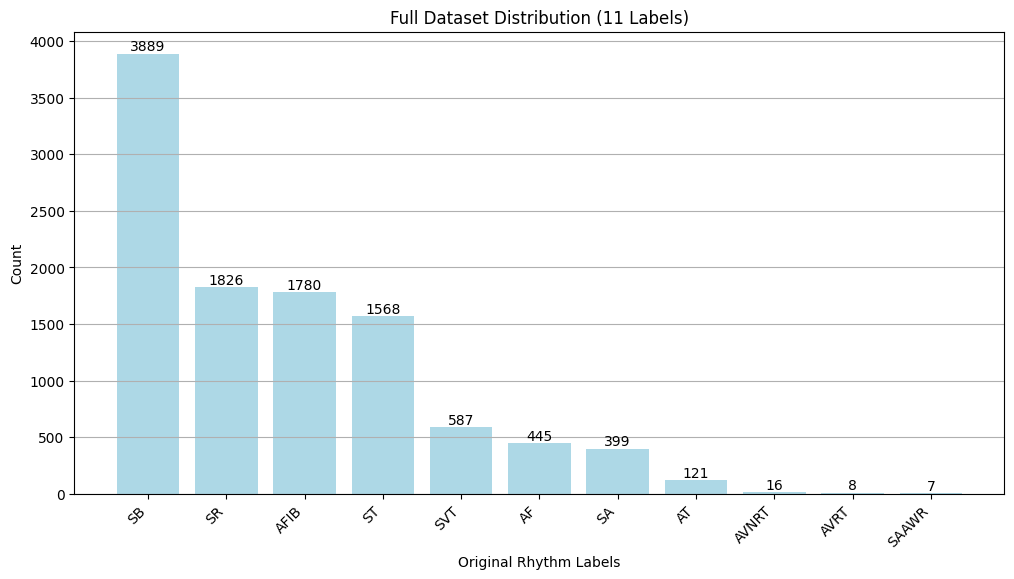

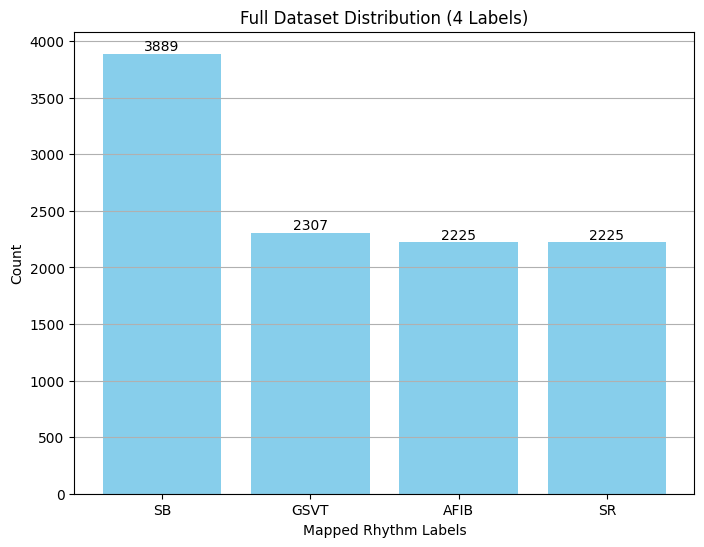

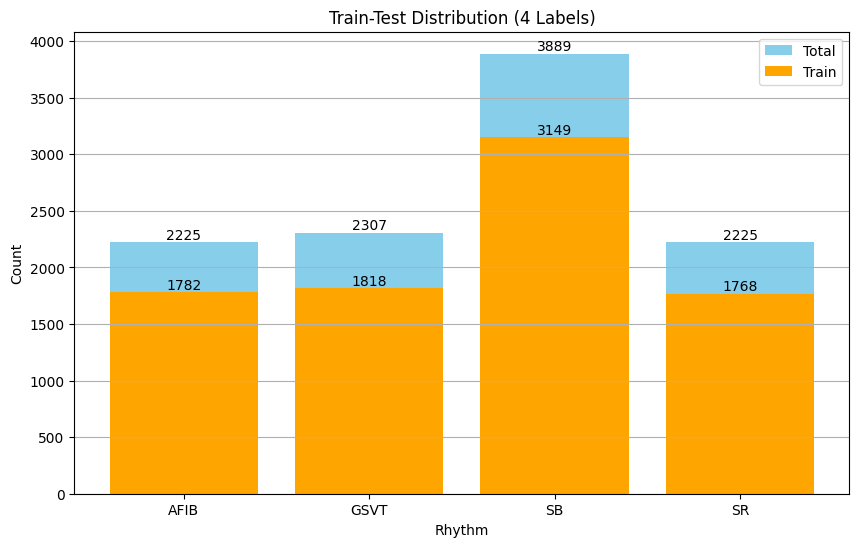

In [25]:
# Step 6: Train-test split and distribution bar chart
def plot_split_distribution(df):
    mapped_rhythms = df['Rhythm'].map(rhythm_mapping)
    df['MappedRhythm'] = mapped_rhythms

    train_df = df.sample(frac=0.8, random_state=42)
    test_df = df.drop(train_df.index)

    train_counts = train_df['MappedRhythm'].value_counts()
    test_counts = test_df['MappedRhythm'].value_counts()

    # Full dataset distribution (11 labels)
    full_counts = df['Rhythm'].value_counts()
    plt.figure(figsize=(12, 6))
    bars = plt.bar(full_counts.index, full_counts.values, color="lightblue")
    for bar, value in zip(bars, full_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(value), ha="center", va="bottom")
    plt.xlabel("Original Rhythm Labels")
    plt.ylabel("Count")
    plt.title("Full Dataset Distribution (11 Labels)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y")
    plt.savefig(os.path.join(OUTPUT_FOLDER, "full_dataset_distribution_11_labels.png"), dpi=300, transparent=True)
    plt.show()

    # Full dataset distribution (4 labels)
    mapped_counts = df['MappedRhythm'].value_counts()
    plt.figure(figsize=(8, 6))
    bars = plt.bar(mapped_counts.index, mapped_counts.values, color="skyblue")
    for bar, value in zip(bars, mapped_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(value), ha="center", va="bottom")
    plt.xlabel("Mapped Rhythm Labels")
    plt.ylabel("Count")
    plt.title("Full Dataset Distribution (4 Labels)")
    plt.grid(axis="y")
    plt.savefig(os.path.join(OUTPUT_FOLDER, "full_dataset_distribution_4_labels.png"), dpi=300, transparent=True)
    plt.show()

    # Train-test split distribution
    rhythms = list(train_counts.index.union(test_counts.index))
    train_values = [train_counts.get(rhythm, 0) for rhythm in rhythms]
    test_values = [test_counts.get(rhythm, 0) for rhythm in rhythms]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(rhythms, [t + v for t, v in zip(train_values, test_values)], color="skyblue", label="Total")
    plt.bar(rhythms, train_values, color="orange", label="Train")

    for bar, train, test in zip(bars, train_values, test_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha="center", va="bottom")
        plt.text(bar.get_x() + bar.get_width()/2, train, str(train), ha="center", va="bottom")

    plt.xlabel("Rhythm")
    plt.ylabel("Count")
    plt.title("Train-Test Distribution (4 Labels)")
    plt.legend()
    plt.grid(axis="y")
    plt.savefig(os.path.join(OUTPUT_FOLDER, "train_test_distribution_combined.png"), dpi=300, transparent=True)
    plt.show()


plot_split_distribution(diagnostics)